In [1]:
import scanpy as sc
import numpy as np
import random
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "E:/_output/"
sample_ID = "Barcode-2"

adata = sc.read_10x_h5(data_path + sample_ID + "/outs/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs["sample_id"] = [sample_ID] * adata.n_obs
adata

reading E:/_output/Barcode-2/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4529 × 22066
    obs: 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'

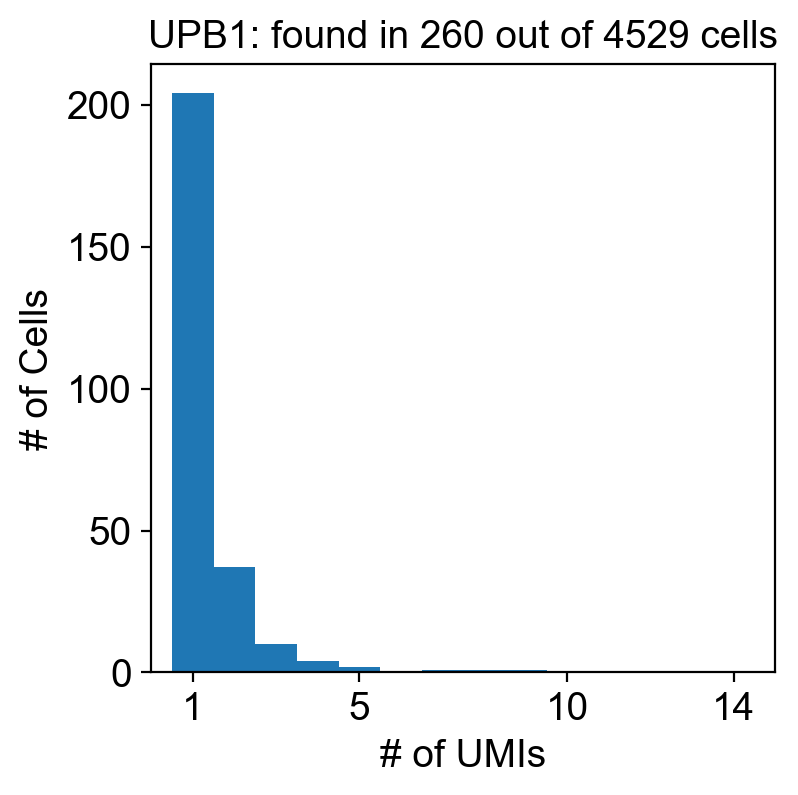

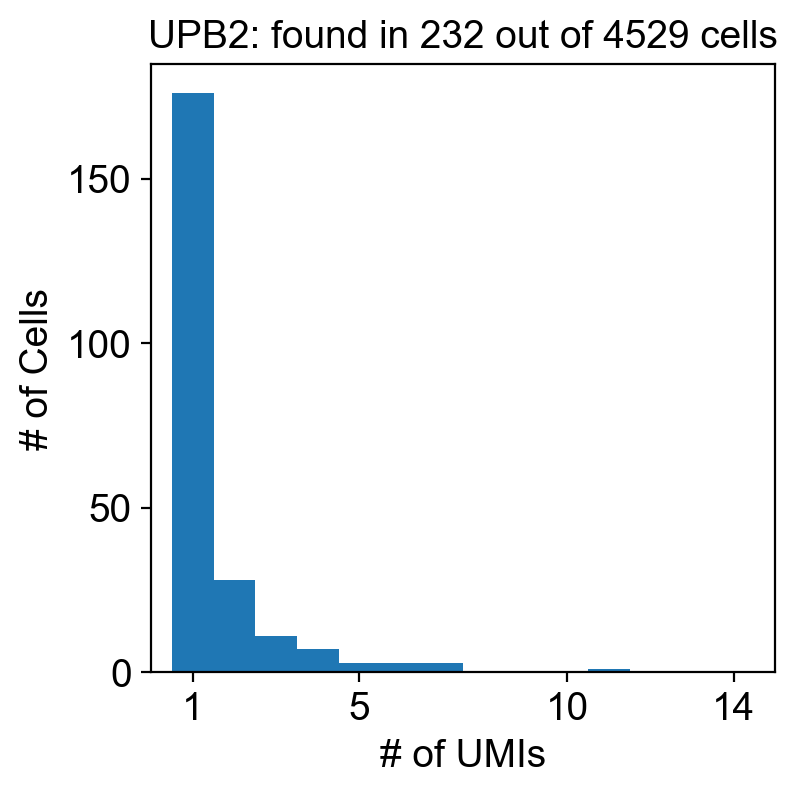

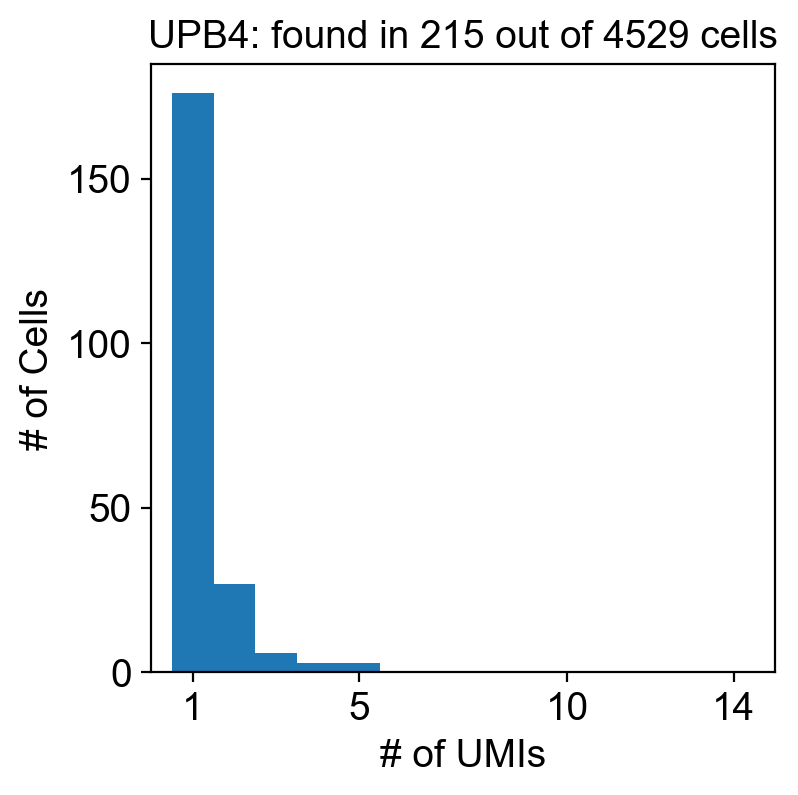

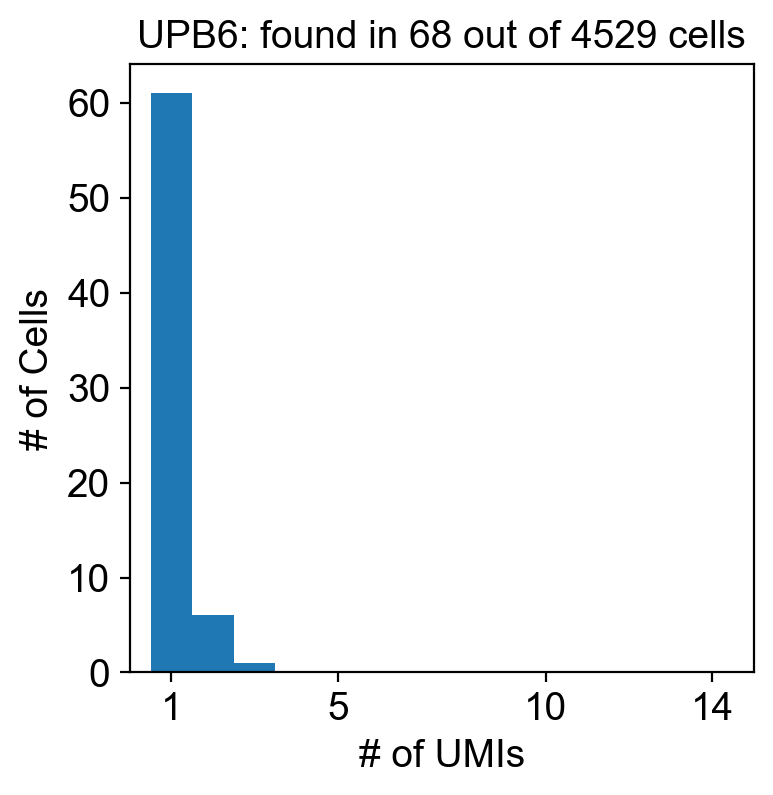

In [2]:
import matplotlib.pyplot as plt

for upb in ["UPB1", "UPB2", "UPB4", "UPB6"]:

    fig, ax = plt.subplots()
    counts = adata[:, upb].X.toarray()
    ax.hist(counts[counts > 0], bins=np.arange(0, 15, 1), log=False)
    ax.set_title("{0}: found in {1} out of {2} cells".format(upb, np.sum(counts > 0).astype(int), counts.size))
    ax.set_xlabel("# of UMIs")
    ax.set_ylabel("# of Cells")
    ax.set_xlim((0.5, 15.5))
    ax.set_xticks((1.5, 5.5, 10.5, 14.5))
    ax.set_xticklabels((1, 5, 10, 14))
    ax.grid(False)
    plt.show(block=False)

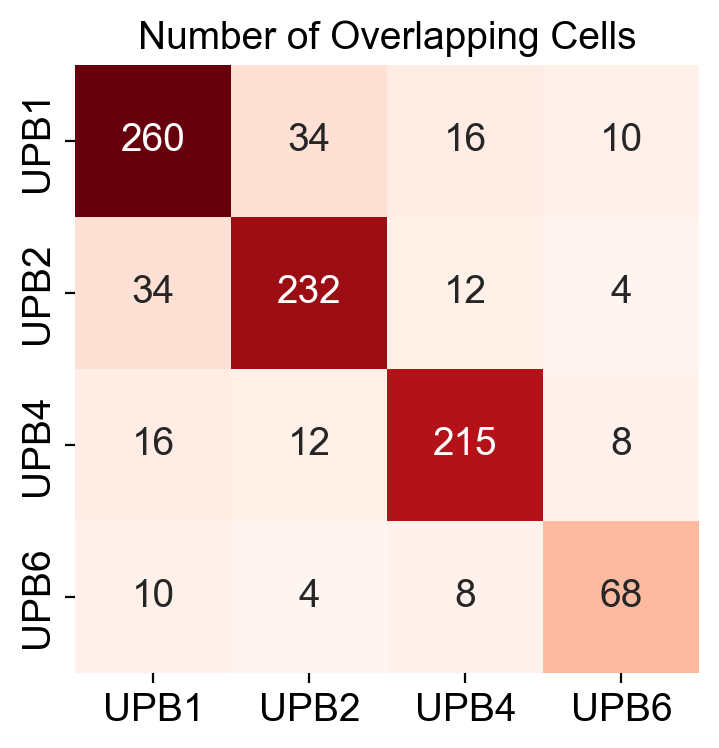

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

matrix = np.array(adata[:, ["UPB1", "UPB2", "UPB4", "UPB6"]].X.toarray()) > 0
matrix = matrix.astype(int)
overlap = np.matmul(matrix.T, matrix)

fig, ax = plt.subplots()
sns.heatmap(overlap, cbar=False, annot=True, fmt=".0f", cmap="Reds")
ax.set_title("Number of Overlapping Cells")
ax.set_xticklabels(("UPB1", "UPB2", "UPB4", "UPB6"))
ax.set_yticklabels(("UPB1", "UPB2", "UPB4", "UPB6"))
ax.grid(False)
plt.show(block=False)

In [4]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_genes(adata, min_cells=8)

filtered out 66 cells that have less than 700 genes expressed
filtered out 6162 genes that are detected in less than 8 cells


In [5]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

In [6]:
adata.obs["n_counts"] = np.sum(adata.X, axis=1)

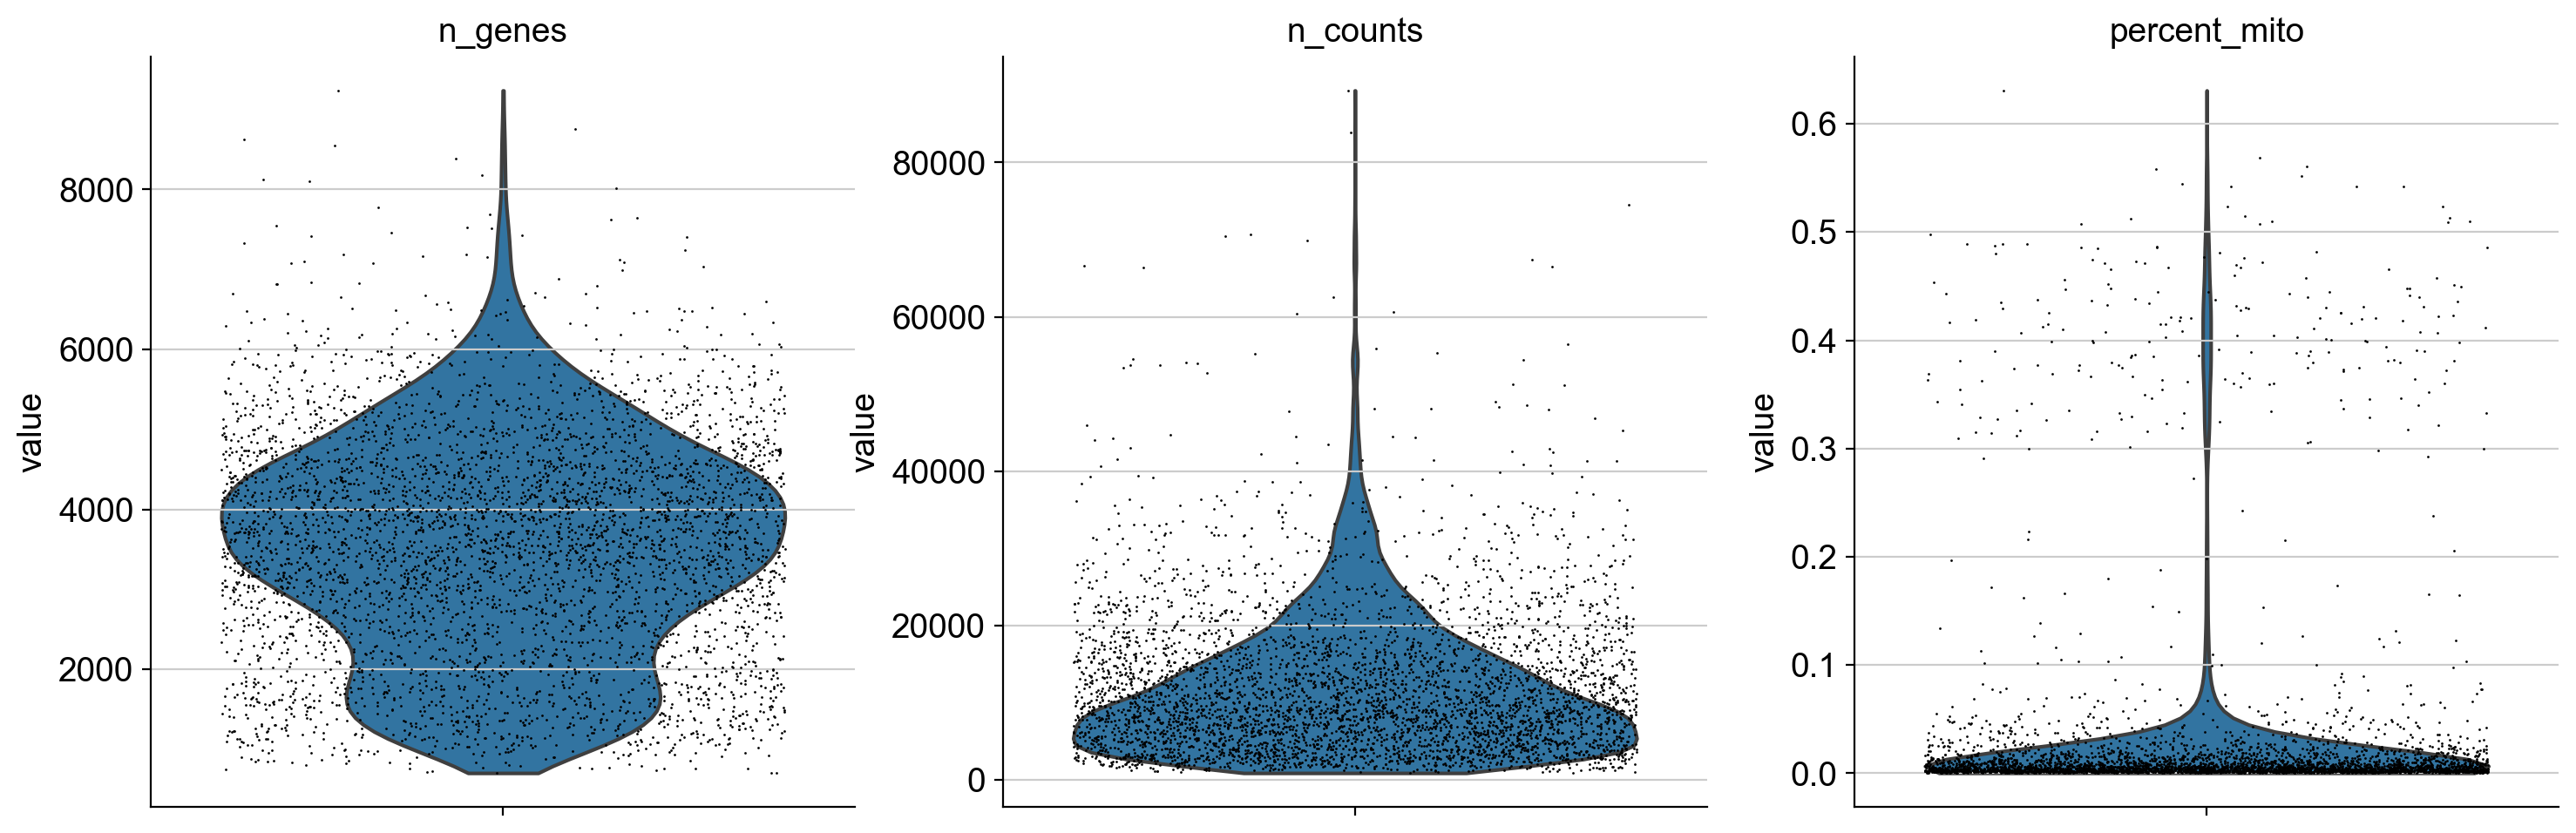

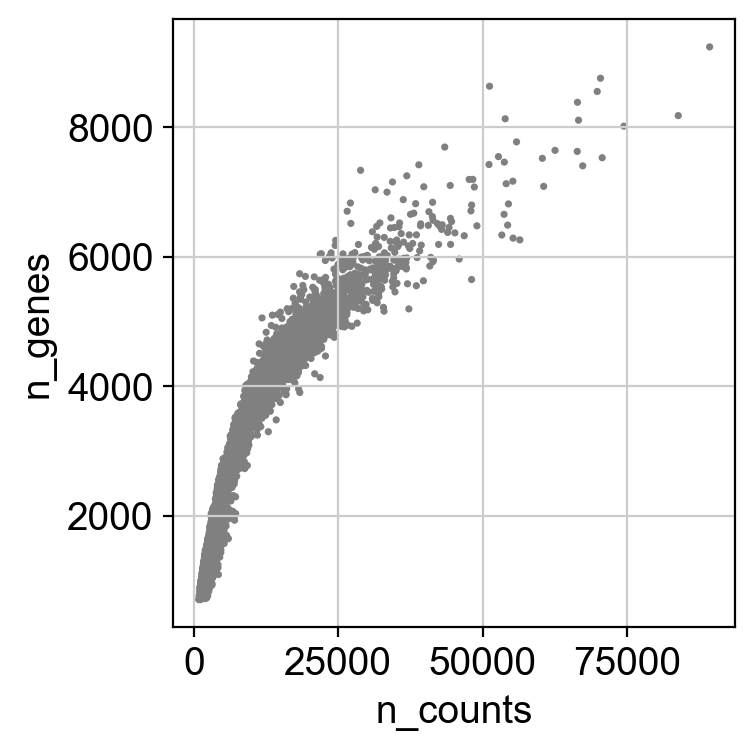

In [7]:
sc.pl.violin(adata, ["n_genes", "n_counts", "percent_mito"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [8]:
adata = adata[adata.obs["percent_mito"] < 0.01, :]
adata = adata[adata.obs["n_genes"] < 6500, :]
adata = adata[adata.obs["n_counts"] < 40000, :]

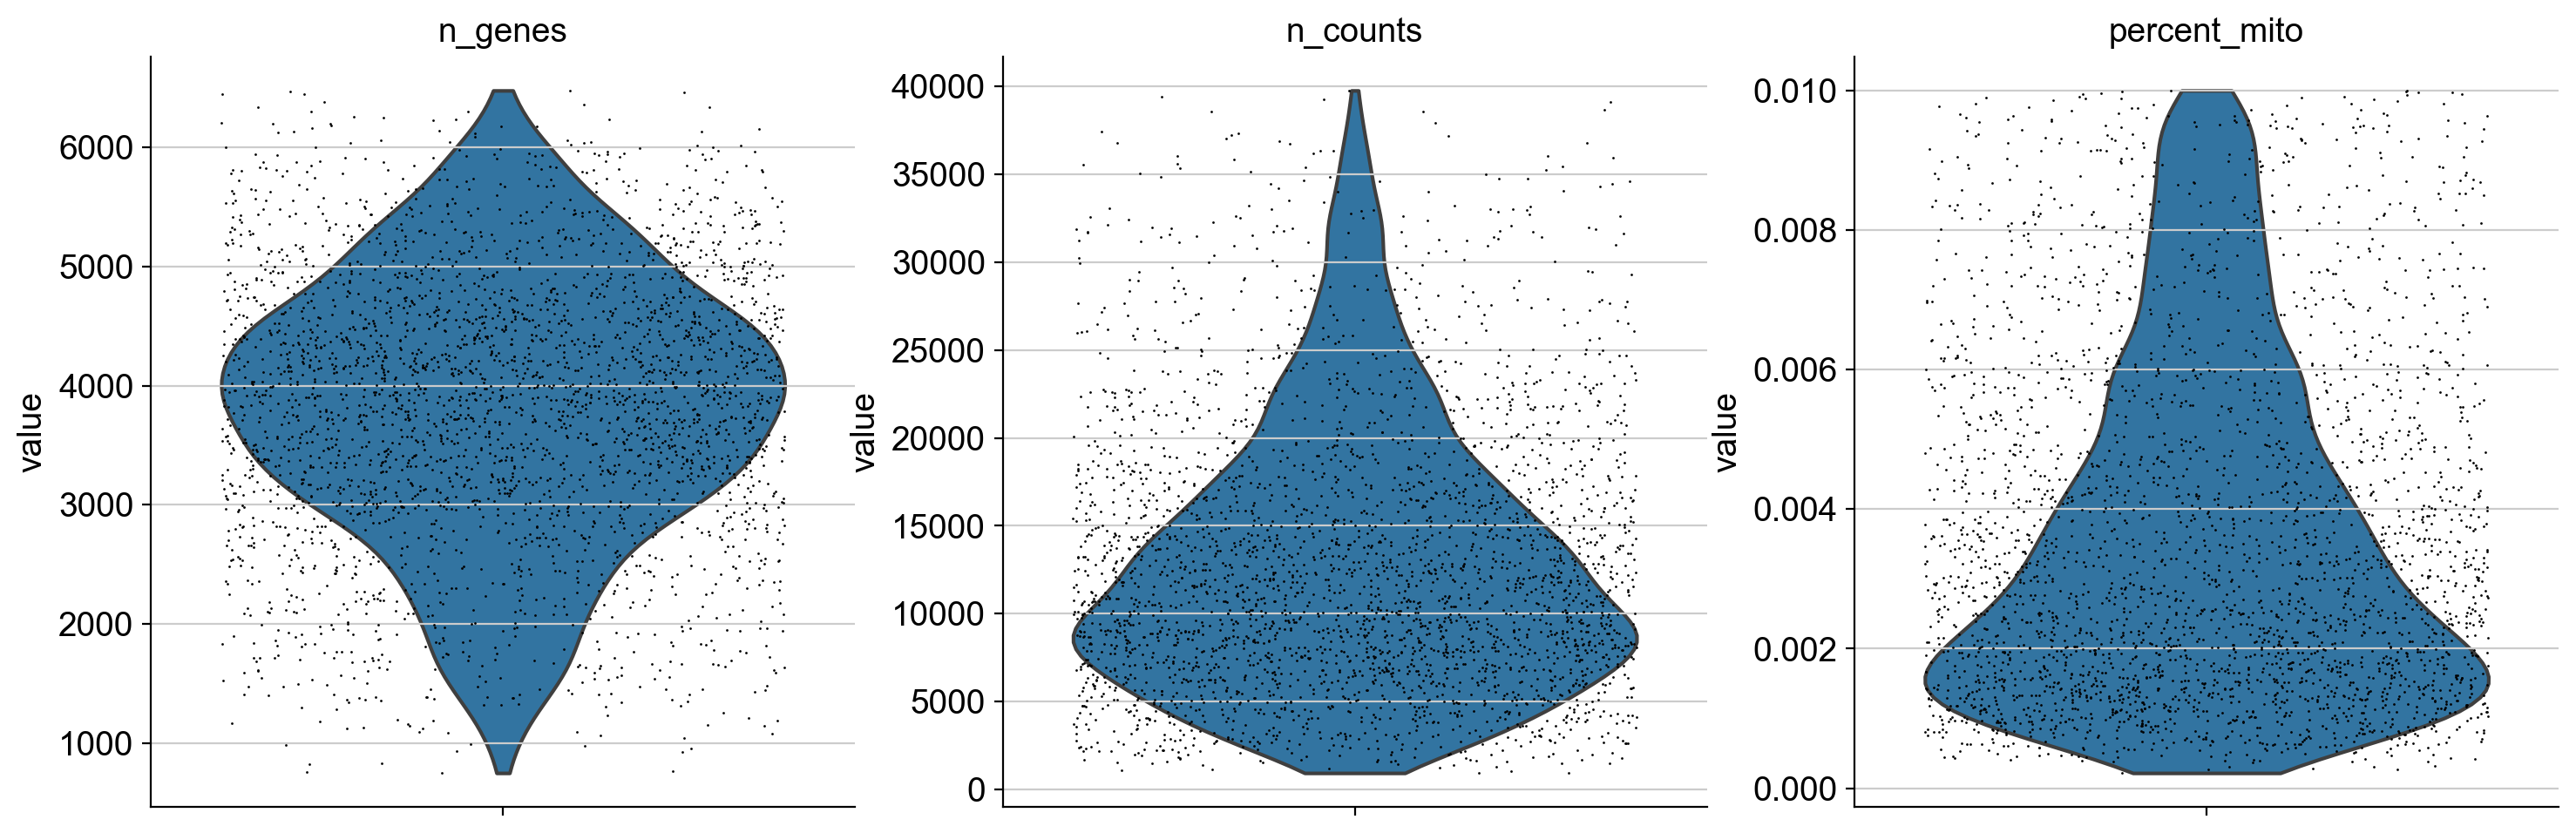

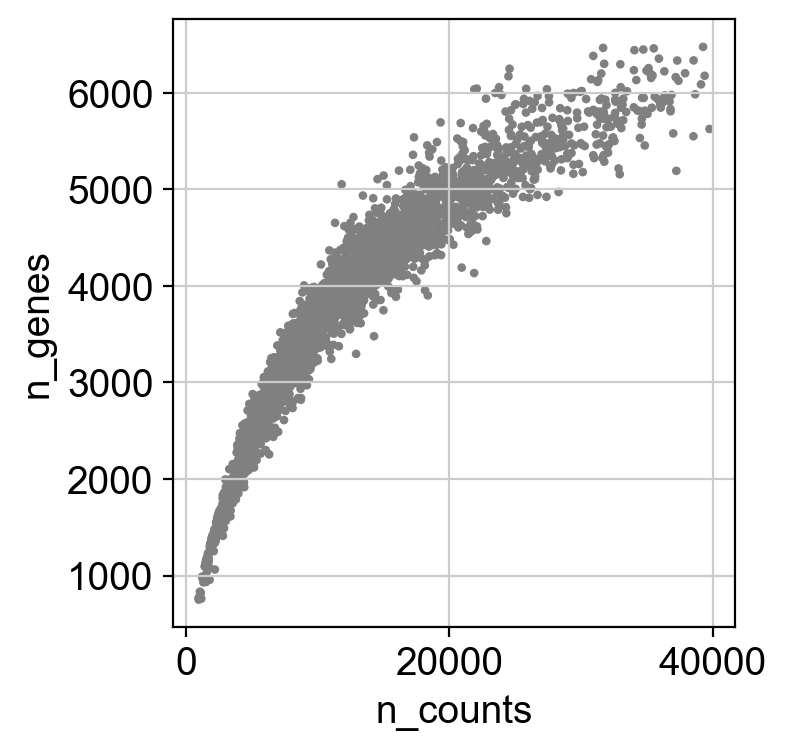

In [9]:
sc.pl.violin(adata, ["n_genes", "n_counts", "percent_mito"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="n_counts", y="n_genes")

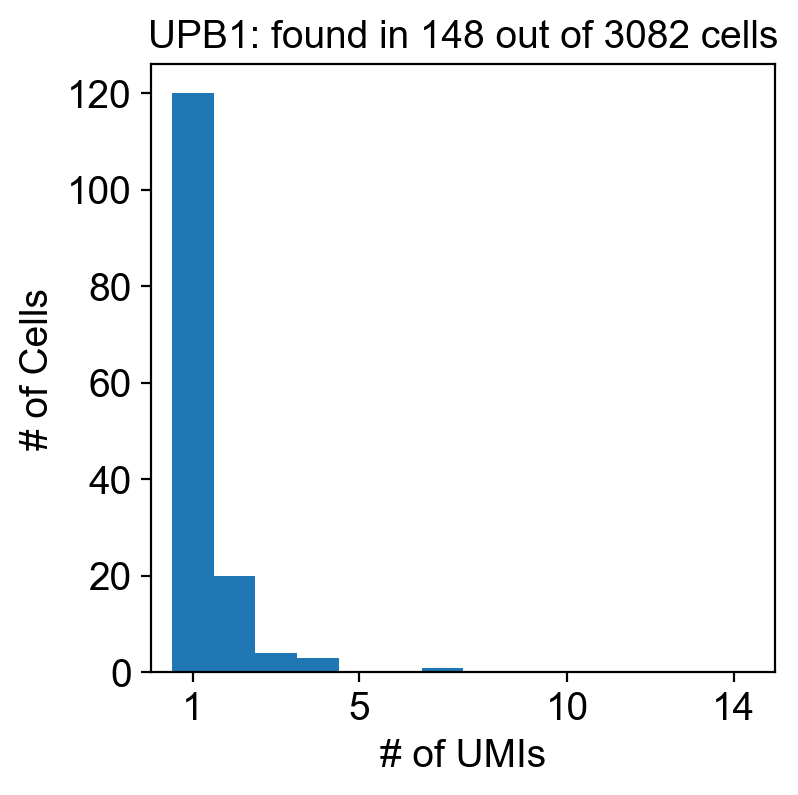

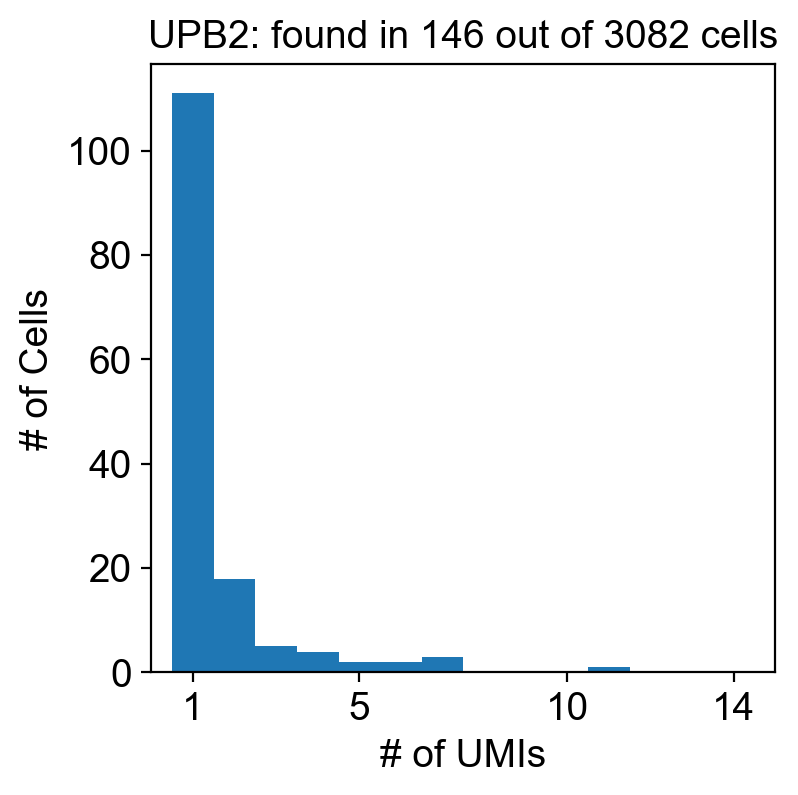

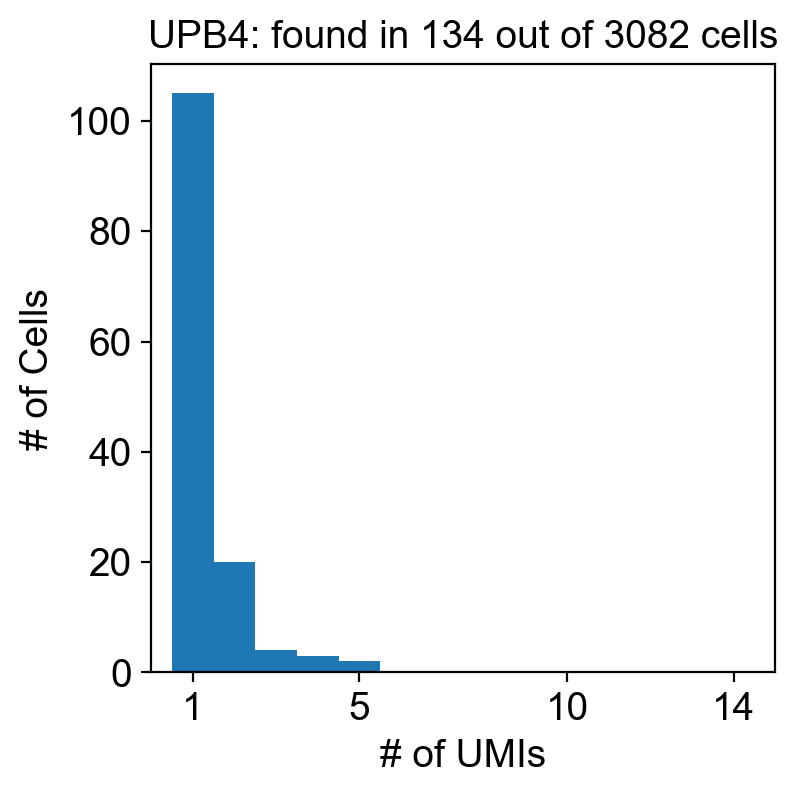

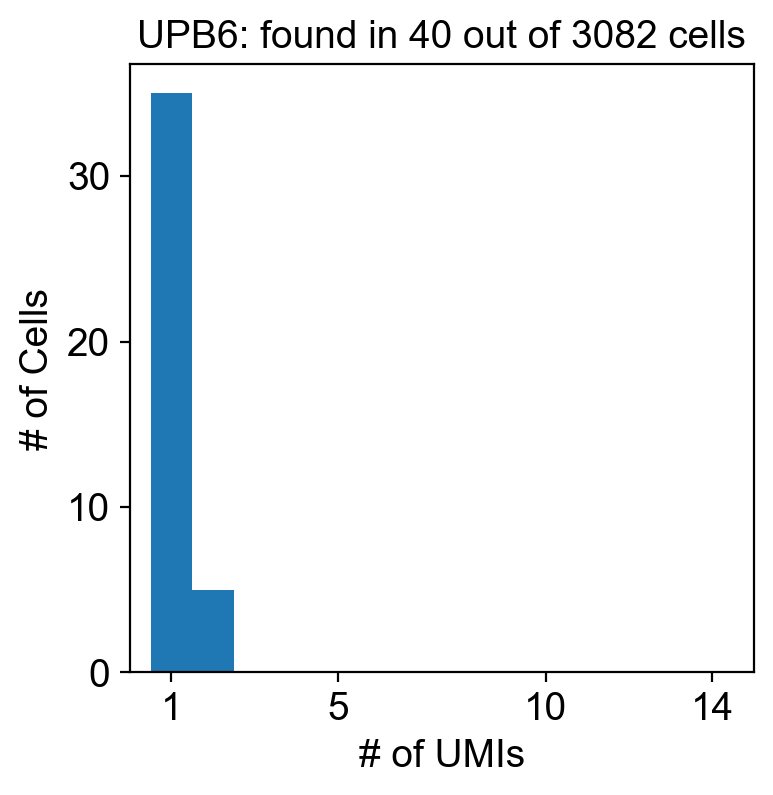

In [10]:
import matplotlib.pyplot as plt

for upb in ["UPB1", "UPB2", "UPB4", "UPB6"]:

    fig, ax = plt.subplots()
    counts = adata[:, upb].X.toarray()
    ax.hist(counts[counts > 0], bins=np.arange(0, 15, 1), log=False)
    ax.set_title("{0}: found in {1} out of {2} cells".format(upb, np.sum(counts > 0).astype(int), counts.size))
    ax.set_xlabel("# of UMIs")
    ax.set_ylabel("# of Cells")
    ax.set_xlim((0.5, 15.5))
    ax.set_xticks((1.5, 5.5, 10.5, 14.5))
    ax.set_xticklabels((1, 5, 10, 14))
    ax.grid(False)
    plt.show(block=False)

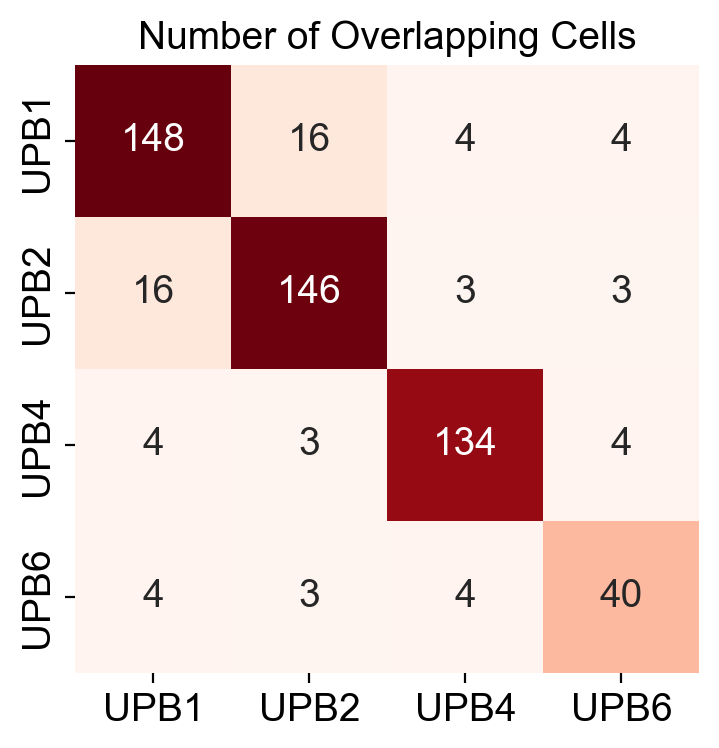

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

matrix = np.array(adata[:, ["UPB1", "UPB2", "UPB4", "UPB6"]].X.toarray()) > 0
matrix = matrix.astype(int)
overlap = np.matmul(matrix.T, matrix)

fig, ax = plt.subplots()
sns.heatmap(overlap, cbar=False, annot=True, fmt=".0f", cmap="Reds")
ax.set_title("Number of Overlapping Cells")
ax.set_xticklabels(("UPB1", "UPB2", "UPB4", "UPB6"))
ax.set_yticklabels(("UPB1", "UPB2", "UPB4", "UPB6"))
ax.grid(False)
plt.show(block=False)

In [12]:
adata_bars = adata.copy()
genes = [g for g in adata.var_names if g not in ["UPB1", "UPB2", "UPB3", "UPB4", "UPB5", "UPB6", "UPB7", "UPB8", "tdTomato"]]
adata = adata[:, genes]

In [13]:
import scrublet as scr

counts_matrix = adata.X
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

doublet_scores, predicted_doublets = scrub.scrub_doublets(min_cells=8, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=40)

adata.obs["doublet"] = scrub.predicted_doublets_
adata.obs["doublet_score"] = scrub.doublet_scores_obs_

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 4.4%
Estimated detectable doublet fraction = 49.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.8%
Elapsed time: 3.8 seconds


C:\Users\TLab\AppData\Local\Temp\ipykernel_15408\1727709204.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet"] = scrub.predicted_doublets_


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

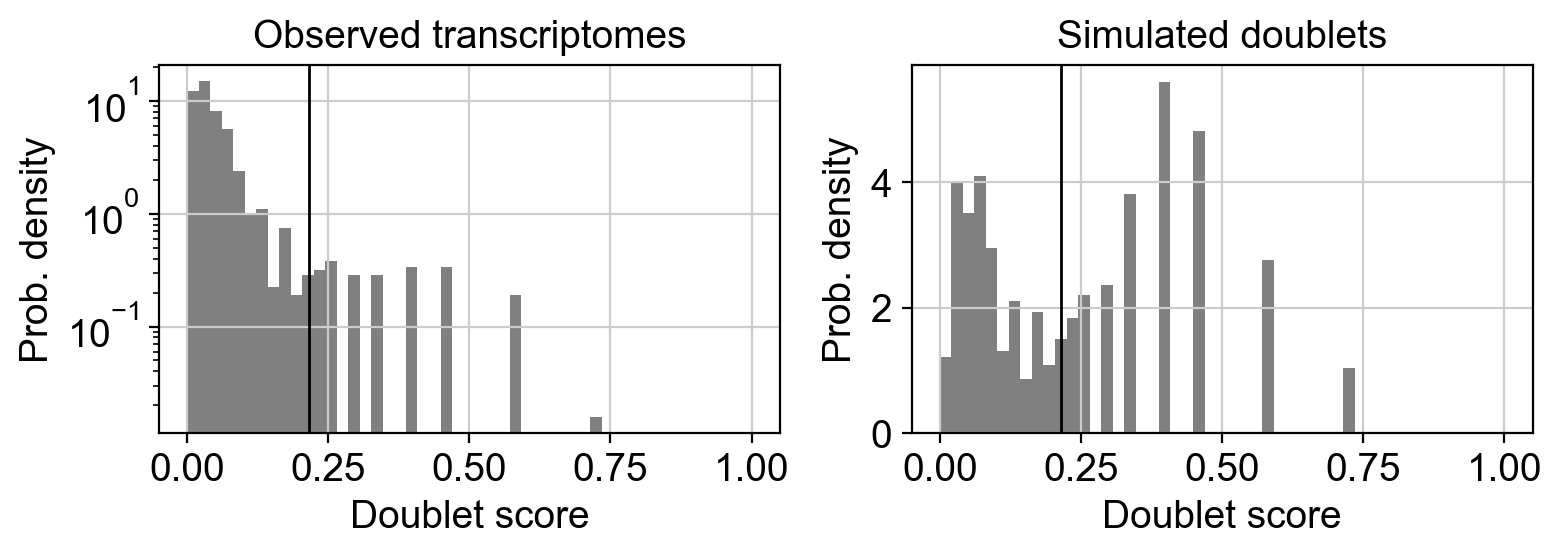

In [14]:
scrub.plot_histogram()

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.write_h5ad(data_path + sample_ID + ".h5ad")
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


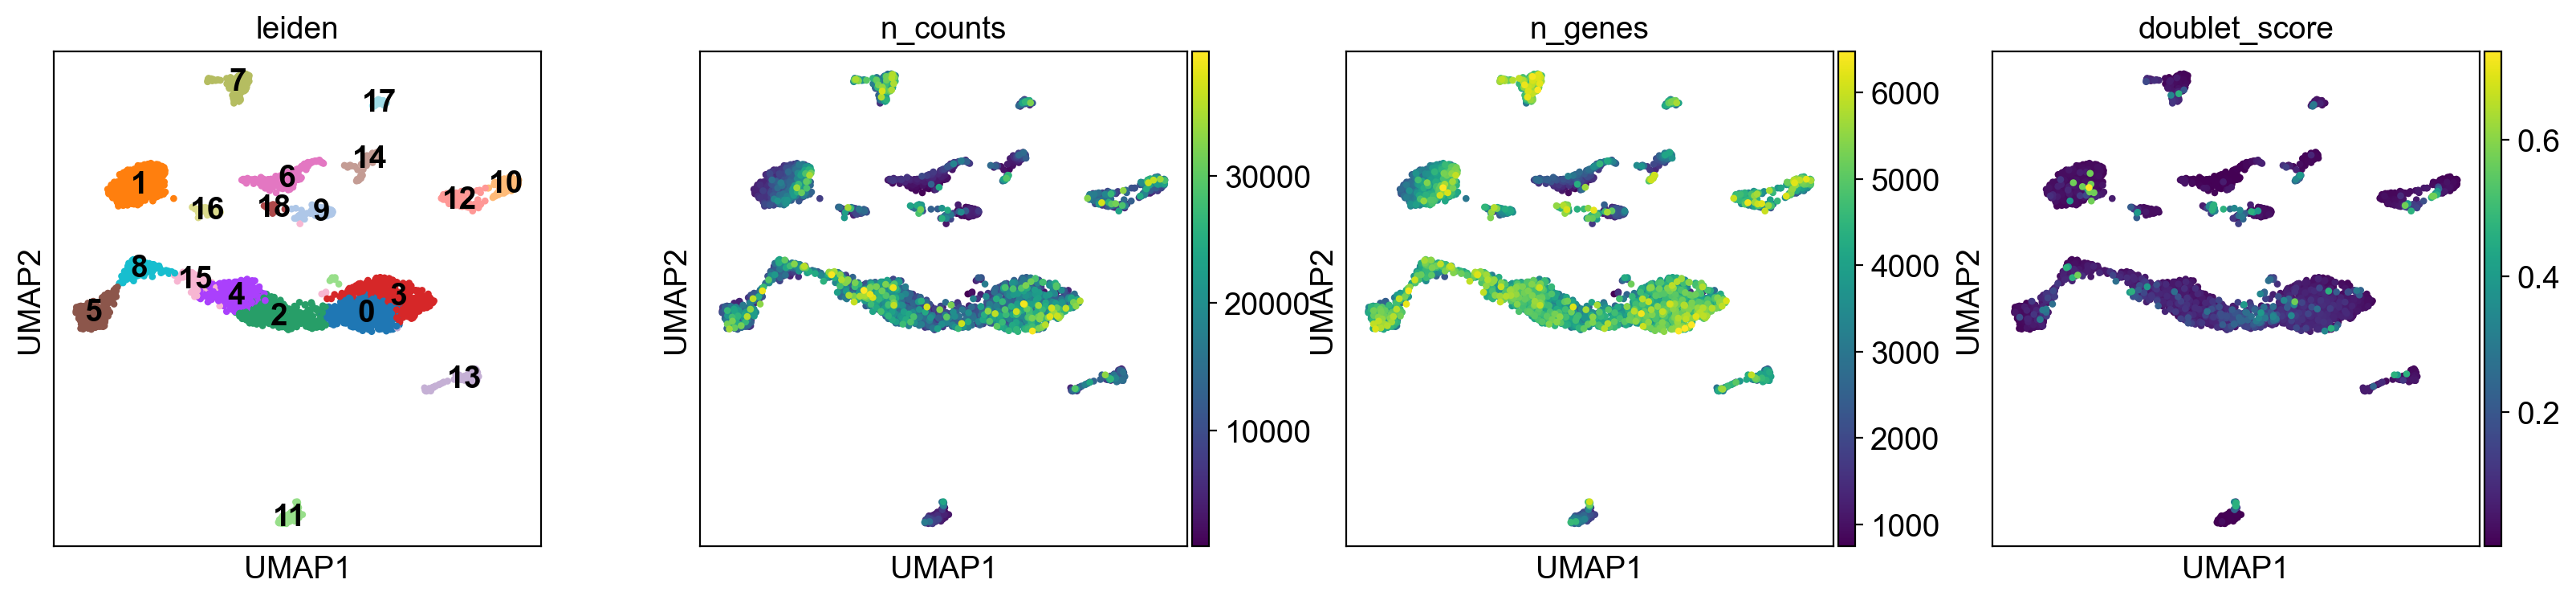

In [16]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "n_counts", "n_genes", "doublet_score"], legend_loc="on data")

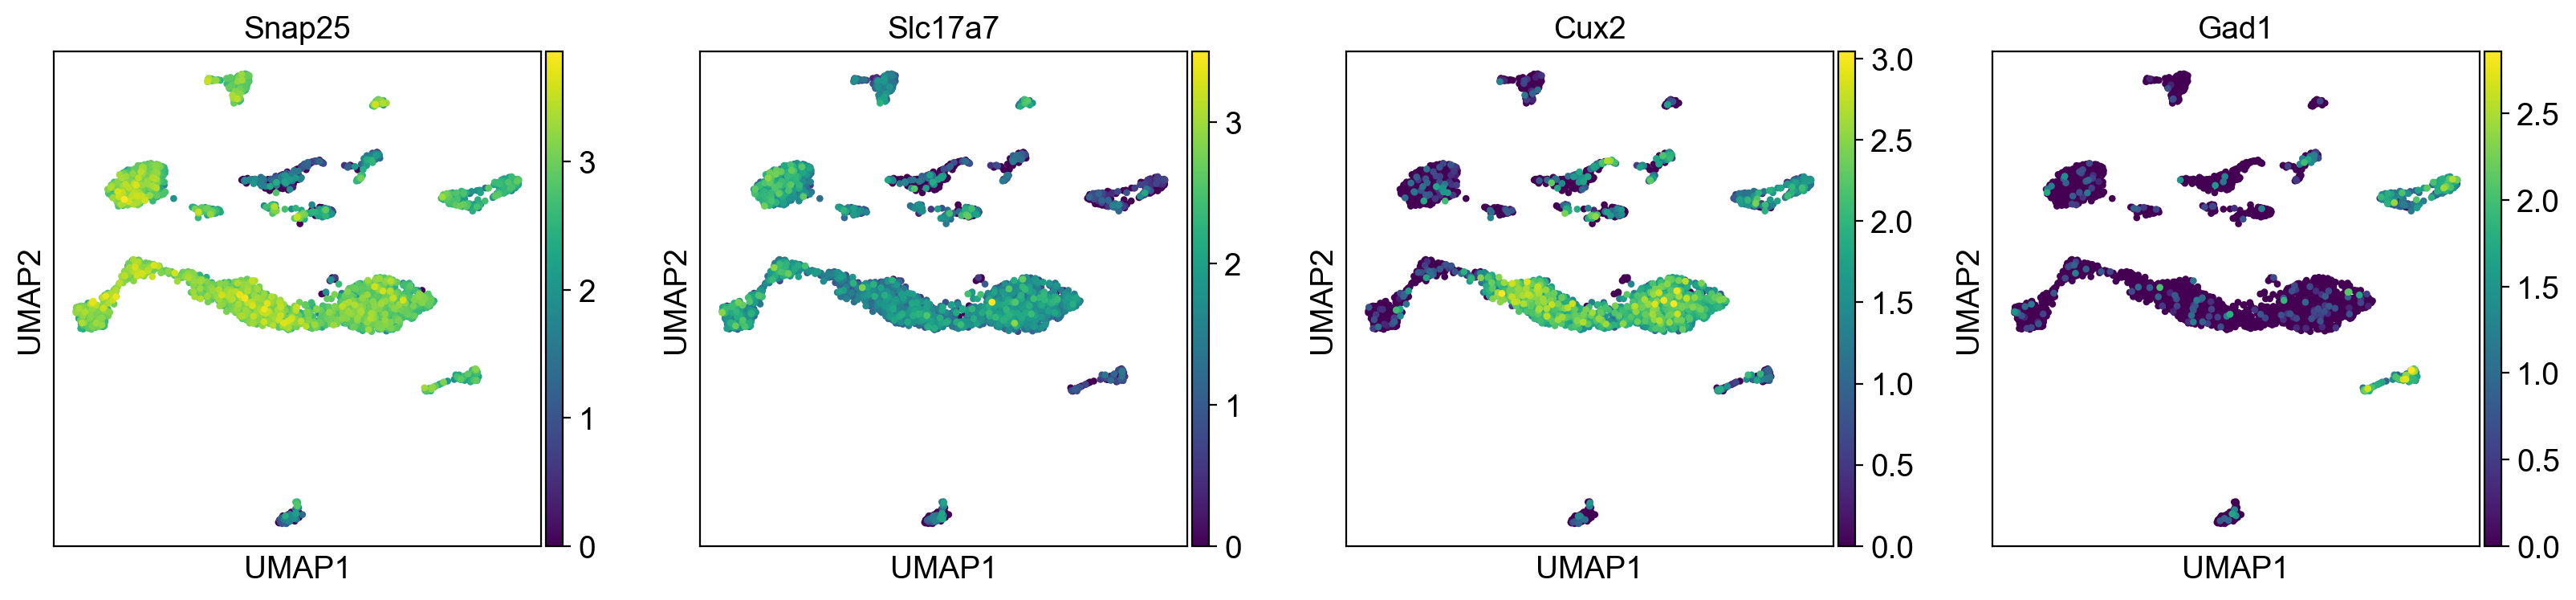

In [17]:
sc.pl.umap(adata, color=["Snap25", "Slc17a7", "Cux2", "Gad1"], legend_loc="on data")

In [18]:
for upb in ["UPB1", "UPB2", "UPB4", "UPB6"]:
    adata.obs.loc[:, upb] = adata_bars[:, upb].X.toarray()

,sample_id,n_genes,percent_mito,n_counts,doublet,doublet_score,leiden,UPB1,UPB2,UPB4,UPB6
AAACCCATCAGCCCAG-1,Barcode-2,1188,0.002533,1579.0,False,0.035403,9,0.0,0.0,0.0,0.0
AAACGAACACAGCGCT-1,Barcode-2,4384,0.002023,14338.0,False,0.051104,5,0.0,0.0,0.0,0.0
AAACGAACACCCTTAC-1,Barcode-2,5979,0.001681,36872.0,False,0.068598,0,0.0,0.0,0.0,0.0
AAACGAAGTTTCTTAC-1,Barcode-2,3535,0.009157,9829.0,False,0.084956,0,0.0,0.0,0.0,0.0
AAACGAATCGTCTACC-1,Barcode-2,2181,0.004660,4935.0,False,0.004182,6,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCATCACGGC-1,Barcode-2,6250,0.001262,24565.0,True,0.340813,9,0.0,0.0,0.0,0.0
TTTGTTGGTGAATGAT-1,Barcode-2,4547,0.000985,18265.0,False,0.114681,4,0.0,0.0,0.0,0.0
TTTGTTGGTGGTCCCA-1,Barcode-2,3341,0.000622,9652.0,False,0.029564,4,0.0,0.0,0.0,0.0
TTTGTTGGTTGATGTC-1,Barcode-2,5198,0.003068,21839.0,False,0.056225,5,0.0,0.0,1.0,0.0


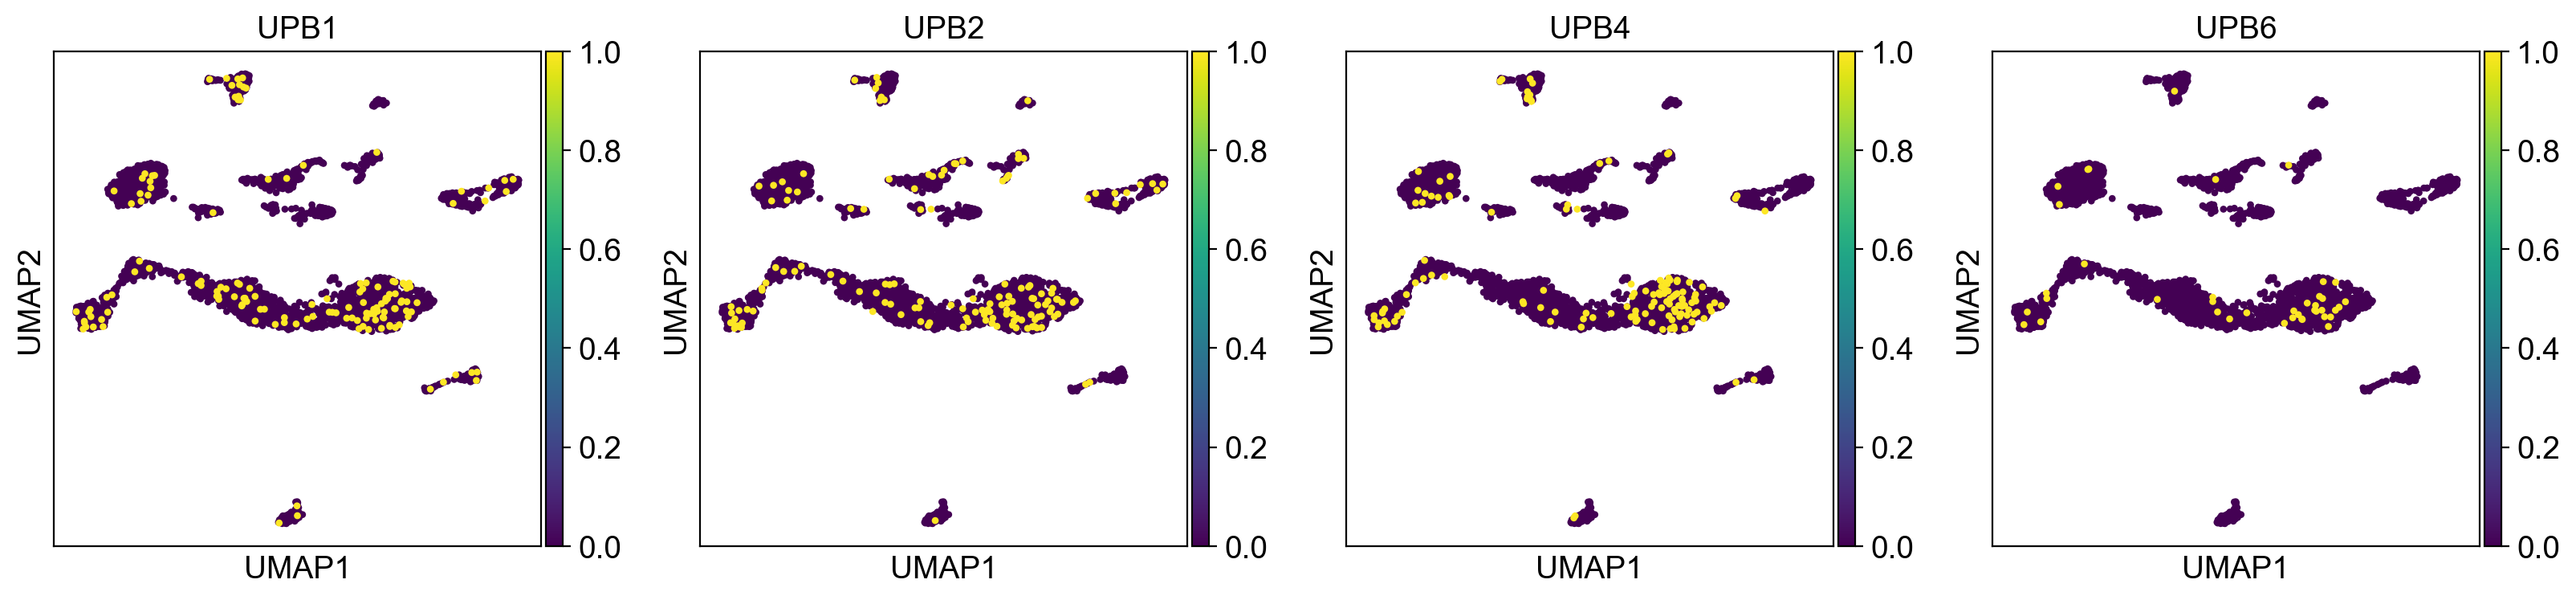

In [20]:
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], legend_loc="on data", vmax=1)